In [1]:
import utils
import models
import executor
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import pandas as pd
from utils import perfect_square_acc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Note: process kodaira symbol if it is not already done
# path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000.parquet"
# df = utils.load_data(path)
# df = utils.process_kodaira_symbol(df)
# df.drop('lmfdb_label', axis=1, inplace=True)
# save the processed data
# df.to_parquet(Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet")

In [2]:
# load your data here if kodaira symbol has been processed
# the data file has its Kodaira symbols already preprocessed 
path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet"
df = utils.load_data(path)

Loaded the dataset with 118 features and 3064705 curves..


In [3]:
df.drop(columns=['conductor','adelic_level'], axis=1, inplace=True)

## Features are:
- first 100 $a_p$
- 'rank'
- 'torsion'
- 'adelic_level': could get large as conductor gets bigger
- 'adelic_index'
- 'adelic_genus' 
- 'real_period'
- 'special_value'
- 'tamagawa_product': could get large as conductor gets bigger
- processed kodaira symbols: 'kodaira_-5.0', 'kodaira_-4.0', 'kodaira_-3.0', 'kodaira_-2.0', 'kodaira_-1.0', 'kodaira_2.0', 'kodaira_3.0', 'kodaira_4.0', 'kodaira_5.0', where 'kodaira_*' is an indicator of *normalized kodaira symbols*
    - *normalized kodaira symbols* converts Kodaira symbol $ks$ as follows:
        - If $ks$ is greater than or equal to 5, it is converted to 5. This represents the Kodaira symbol which indicates multiplicative reduction.
        - If $ks$ is less than or equal to -5, it is converted to -5. This represents the Kodaira symbol which indicates potential multiplicative reduction.
        - If $ks$ is between -4 and 4 (inclusive), it is left unchanged. These values represent potential good reduction.
    - example: if the list of Kodaira symbols PARI encoding for the bad primes is [4, 7], then 'kodaira_4.0' = 1, 'kodaira_5.0' = 1, and all other 'kodaira_*' are 0.

In [5]:
# to get a balanced dataset with equal amount of 4 and 9 labels
len_9 = df[df['sha'] == 9].shape[0]

df_balanced = df[df['sha'] == 4].sample(len_9) 
# df_balanced = df[df['sha'] == 4].iloc[:len_9]

df_balanced = pd.concat([df_balanced, df[df['sha'] == 9]])

# rename 4 to 0 and 9 to 1
df_balanced['sha'] = df_balanced['sha'].replace({4: 0, 9: 1})

# all features

## logistic regression

In [6]:
# split the data into training and testing
X = df_balanced.drop('sha', axis=1)
y = df_balanced['sha']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

model = LogisticRegression()
# train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
print('accuracy_score:', accuracy_score(y_test, y_pred))

accuracy_score: 0.6898671425738647


## NN

In [7]:
# choose model parameters
# hidden_units = [128,64,32]
# hidden_units = [64,32,16]
hidden_units = [32,16,8]
# hidden_units = [16,8,4]
# hidden_units = [8,4,2]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_balanced, 'sha', if_regression=False)

# check if we have cuda available
device = utils.get_device()

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=True, dropout_rate=0.5, if_batchnorm=True).to(device)

# print model summary
utils.model_summary(model)

The input dimension is 116 and the output dimension is 2.
Device: cpu.
The model has 4,538 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=116, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=8, out_features=2, bias=True)
  )
)


In [11]:
# choose training parameters
loss_func = nn.CrossEntropyLoss()
num_epochs = 50
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = accuracy_score

Epoch 1/50. Training CrossEntropyLoss : 0.3814, Validation CrossEntropyLoss : 0.4443. Training accuracy_score: 0.8951, Validation accuracy_score: 0.8937
Epoch 2/50. Training CrossEntropyLoss : 0.3829, Validation CrossEntropyLoss : 0.4308. Training accuracy_score: 0.8605, Validation accuracy_score: 0.8588
Epoch 3/50. Training CrossEntropyLoss : 0.3766, Validation CrossEntropyLoss : 0.4137. Training accuracy_score: 0.8979, Validation accuracy_score: 0.8950
Epoch 4/50. Training CrossEntropyLoss : 0.3852, Validation CrossEntropyLoss : 0.4326. Training accuracy_score: 0.8147, Validation accuracy_score: 0.8166
Epoch 5/50. Training CrossEntropyLoss : 0.3823, Validation CrossEntropyLoss : 0.4432. Training accuracy_score: 0.8707, Validation accuracy_score: 0.8709
Epoch 6/50. Training CrossEntropyLoss : 0.3740, Validation CrossEntropyLoss : 0.4324. Training accuracy_score: 0.8807, Validation accuracy_score: 0.8817
Epoch 7/50. Training CrossEntropyLoss : 0.3764, Validation CrossEntropyLoss : 0.40

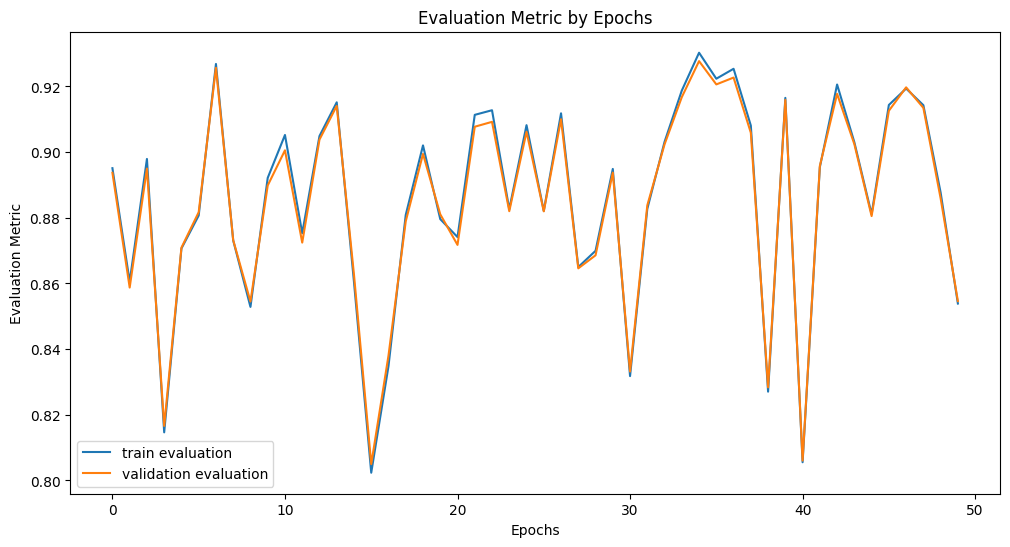

In [12]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced, 'sha', device, if_regression=False)
# train the model
model, train_eval_hist, val_eval_hist, train_loss_hist, val_loss_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=False, verbose=True)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

In [13]:
# print test accuracy, precision, recall
acc = executor.test(model, test_dataset, evaluator, if_regression = False)
prec = executor.test(model, test_dataset, precision_score, if_regression = False)
recall = executor.test(model, test_dataset, recall_score, if_regression = False)
print(f"Test accuracy : {acc:0.4f}, precision : {prec:0.4f}, recall : {recall:0.4f}")

Test accuracy : 0.9047, precision : 0.9848, recall : 0.8205


# just $a_p$

In [14]:
df_balanced_ap = df_balanced[list(df_balanced.columns[:100])+['sha']]

## logistic regression

In [15]:
# split the data into training and testing
X = df_balanced_ap.drop('sha', axis=1)
y = df_balanced_ap['sha']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

model = LogisticRegression()
# train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
print('accuracy_score:', accuracy_score(y_test, y_pred))

accuracy_score: 0.5951814396192743


## NN

In [16]:
# choose model parameters
# hidden_units = [128,64,32]
# hidden_units = [64,32,16]
hidden_units = [32,16,8]
# hidden_units = [16,8,4]
# hidden_units = [8,4,2]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_balanced_ap, 'sha', if_regression=False)

# check if we have cuda available
device = utils.get_device()

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=True, dropout_rate=0.5, if_batchnorm=True).to(device)
# model = models.VanillaNN(input_dim, hidden_units, output_dim).to(device)

# print model summary
utils.model_summary(model)

The input dimension is 100 and the output dimension is 2.
Device: cpu.
The model has 4,026 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=8, out_features=2, bias=True)
  )
)


In [17]:
# choose training parameters
loss_func = nn.CrossEntropyLoss()
num_epochs = 50
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = accuracy_score

Epoch 1/50. Training CrossEntropyLoss : 0.6930, Validation CrossEntropyLoss : 0.6940. Training accuracy_score: 0.5122, Validation accuracy_score: 0.5179
Epoch 2/50. Training CrossEntropyLoss : 0.6825, Validation CrossEntropyLoss : 0.6842. Training accuracy_score: 0.5904, Validation accuracy_score: 0.5874
Epoch 3/50. Training CrossEntropyLoss : 0.6768, Validation CrossEntropyLoss : 0.6789. Training accuracy_score: 0.5981, Validation accuracy_score: 0.5940
Epoch 4/50. Training CrossEntropyLoss : 0.6732, Validation CrossEntropyLoss : 0.6766. Training accuracy_score: 0.6052, Validation accuracy_score: 0.5937
Epoch 5/50. Training CrossEntropyLoss : 0.6707, Validation CrossEntropyLoss : 0.6739. Training accuracy_score: 0.6088, Validation accuracy_score: 0.5972
Epoch 6/50. Training CrossEntropyLoss : 0.6694, Validation CrossEntropyLoss : 0.6753. Training accuracy_score: 0.6099, Validation accuracy_score: 0.6004
Epoch 7/50. Training CrossEntropyLoss : 0.6682, Validation CrossEntropyLoss : 0.67

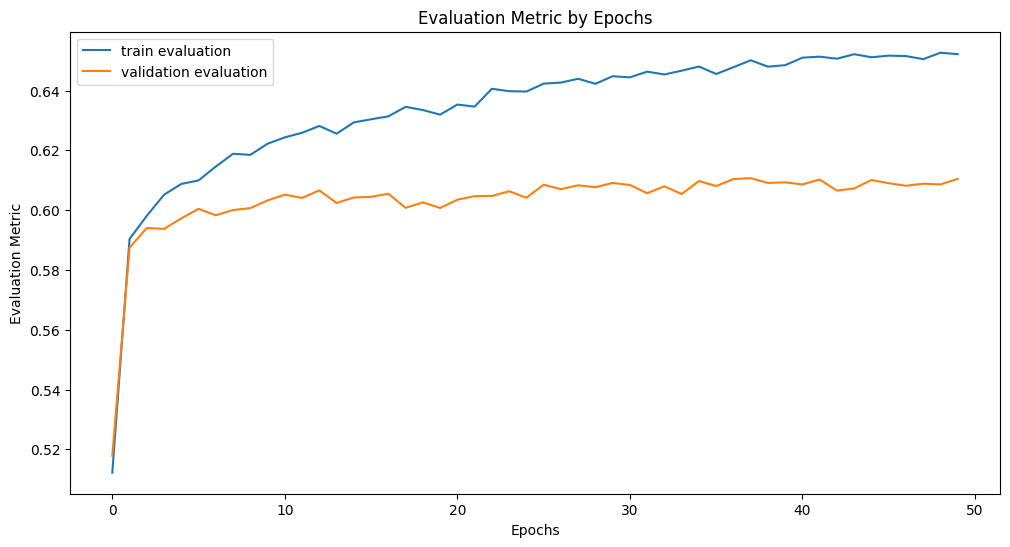

In [18]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced_ap, 'sha', device, if_regression=False)
# train the model
model, train_eval_hist, val_eval_hist, train_loss_hist, val_loss_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=False, verbose=True)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

In [19]:
# print test accuracy, precision, recall
acc = executor.test(model, test_dataset, evaluator, if_regression = False)
prec = executor.test(model, test_dataset, precision_score, if_regression = False)
recall = executor.test(model, test_dataset, recall_score, if_regression = False)
print(f"Test accuracy : {acc:0.4f}, precision : {prec:0.4f}, recall : {recall:0.4f}")

Test accuracy : 0.6172, precision : 0.6394, recall : 0.5224


# With all BSD features

In [ ]:
# load your data here if kodaira symbol has been processed
# the data file has its Kodaira symbols already preprocessed 
path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_reg.parquet"
df = utils.load_data(path)
df_BSD = df[['rank', 'special_value', 'torsion', 'regulator', 'real_period', 'tamagawa_product','sha']]

In [39]:
# to get a balanced dataset with equal amount of 4 and 9 labels
len_9 = df_BSD[df_BSD['sha'] == 9].shape[0]

df_BSD_balanced = df_BSD[df_BSD['sha'] == 4].sample(len_9) 
# df_balanced = df[df['sha'] == 4].iloc[:len_9]

df_BSD_balanced = pd.concat([df_BSD_balanced, df_BSD[df_BSD['sha'] == 9]])

# rename 4 to 0 and 9 to 1
df_BSD_balanced['sha'] = df_BSD_balanced['sha'].replace({4: 0, 9: 1})

## logistic regression

In [ ]:
# split the data into training and testing
X = df_BSD_balanced.drop('sha', axis=1)
y = df_BSD_balanced['sha']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

model = LogisticRegression()
# train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
print('accuracy_score:', accuracy_score(y_test, y_pred))

# just load a trained model and see the result

In [ ]:
# # load data
# path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet"
# df = utils.load_data(path)

# # load torch model
# import torch
# model = torch.load(Path("..") / "trained_models" / "model.pth")

# # split data
# train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced, 'sha', device, if_regression=True)
# X_test, y_test = test_dataset.tensors

# # test the model
# model.eval()
# outputs = model(X_test)
# y_pred = outputs.squeeze()

# # get the l1 distance between the predicted and actual values
# loss = torch.nn.L1Loss()
# loss(y_pred, y_test)